### 对抗生成网络

#### ***GAN*** 网络流程图
<img src="./assets/GAN过程示意图.png" style="margin-left: 0px" width=500px>

***目标*** ：让生成器（Generator）从100维随机噪声生成逼真的数字"2"（28×28×1灰度图），并欺骗判别器（Discriminator）将其判定为真实图像（输出概率越接近1，说明生成质量越高）。

#### ***辨别器*** 的两种输入
<img src="./assets/辨别器的两种输入.png" style="margin-left: 0px" width=500px>


***目标*** ：准确区分真实图像与生成图像：对于输入图像，输出一个0~1的判别概率值，其中接近1表示判定为真实数据（如真实手写数字），接近0则表示判定为生成数据（如生成器合成的图像）

***简单来说***

***判别器*** 像 ***验钞机*** ，给它一张图，它输出一个0~1的数：
1. 接近1 → "真的！"（比如真实手写数字）
2. 接近0 → "假的！"（比如生成器造的图）

***生成器*** 像 ***造假币*** 的：
拼命改进假币质量，想让验钞机输出"1"（以为是真的）

***两者互相斗*** ：
验钞机升级→生成器跟着升级→直到假币逼真到验钞机分不清（输出0.5）

***目标函数（损失函数）*** 定义：一方面要让判别器分辨能力更强，另一方面要让生成器更真

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

%matplotlib inline
print("是否检测到GPU:", tf.config.list_physical_devices('GPU'))

是否检测到GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
noise_dim = 100 # 向量的维度
img_shape = 784  # 28x28
batch_size = 128
epochs = 50
learning_rate = 1e-4

#### ***加载数据***

In [3]:
# 数据集下载地址：https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz

# 指定本地路径
path = './mnist.npz'
with np.load(path, allow_pickle=True) as f:
    train_images, train_labels = f['x_train'], f['y_train']
    test_images, test_labels = f['x_test'], f['y_test']

# 归一化
train_images = train_images / 255.0

In [4]:
train_samples = train_images.shape[0]  # 训练集图片数
test_samples = test_images.shape[0]    # 测试集图片数
print(f"训练集图片数: {train_samples}")  # 输出: 60000
print(f"测试集图片数: {test_samples}")    # 输出: 10000

训练集图片数: 60000
测试集图片数: 10000


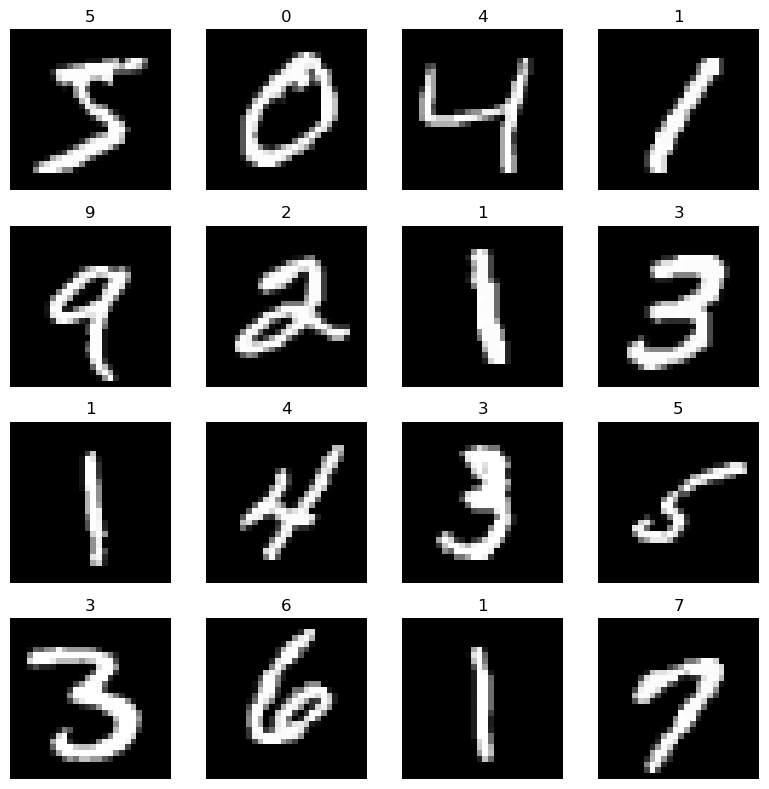

In [5]:
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(train_labels[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
train_images = train_images.reshape(-1, 784).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size, drop_remainder=True)

#### ***数据目标优化***

<img src="./assets/优化目标.png" style="margin-left: 0px" width=800px>

#### ***模型的构造***

##### DCGAN网络

In [7]:
def build_generator(noise_dim):
    model = tf.keras.Sequential([
        layers.Input(shape=(noise_dim,)),
        layers.Dense(7*7*256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', activation='tanh'),
        layers.Reshape((784,))  # 保持输出为展平形式
    ], name='generator')

    model.summary()
    return model

def build_discriminator(img_shape):
    # 创建一个新的Sequential模型
    model = tf.keras.Sequential(name='discriminator')

    # 添加输入层
    model.add(layers.InputLayer(input_shape=(img_shape,)))

    # 根据输入类型添加Reshape层（如果需要）
    if isinstance(img_shape, int):
        model.add(layers.Reshape((28, 28, 1)))

    # 添加卷积层
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    return model


In [8]:
# GAN 模型初始化
generator = build_generator(noise_dim)
discriminator = build_discriminator(img_shape)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        51

#### ***构造目标函数（损失函数）***

In [9]:
# 损失函数和优化器
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# 判别器损失
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # 真实为1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # 假为0
    return real_loss + fake_loss

# 生成器损失
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # 想骗过判别器

***Adam优化器*** 是一种 自适应学习率（adaptive learning rate）优化器，它能够 自动调节学习率，以更有效地优化模型的参数。

In [10]:
d_optimizer = tf.keras.optimizers.Adam(learning_rate)
g_optimizer = tf.keras.optimizers.Adam(learning_rate)

#### ***构造训练函数***

In [11]:
# 用于存储损失值
d_losses = []
g_losses = []

def train_step(real_images, epoch):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        d_loss = discriminator_loss(real_output, fake_output)
        g_loss = generator_loss(fake_output)

    gradients_of_generator = g_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = d_tape.gradient(d_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # 记录损失到数组
    d_losses.append(d_loss.numpy())  # 转换为普通数字并保存
    g_losses.append(g_loss.numpy())  # 转换为普通数字并保存

    return d_loss, g_loss


#### ***构造可视化函数***

可视化每轮epoch生成器生成的假图像

In [12]:
def generate_and_save_images(model, epoch, test_input):
    # 生成图像（关闭训练模式）
    predictions = model(test_input, training=False)

    # 创建图形
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i].numpy().reshape((28, 28)), cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.show()  # 显示图像


可视化生成器和判别器的loss变化

In [13]:
def plot_gan_losses(d_losses, g_losses, steps_per_epoch):
    plt.figure(figsize=(12, 5))

    # 计算 epochs
    epochs = np.arange(len(d_losses)) / steps_per_epoch

    # 子图1：判别器损失
    plt.subplot(1, 2, 1)
    plt.plot(epochs, d_losses, color='red', label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Discriminator Loss')
    plt.grid(True)
    plt.legend()

    # 子图2：生成器损失
    plt.subplot(1, 2, 2)
    plt.plot(epochs, g_losses, color='blue', label='Generator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Generator Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

#### ***主函数训练***

Epoch 1/50: 100%|██████████| 468/468 [00:34<00:00, 13.44it/s]


Epoch 1, D_loss: 1.2613, G_loss: 0.6882


Epoch 2/50: 100%|██████████| 468/468 [00:31<00:00, 14.90it/s]


Epoch 2, D_loss: 0.8323, G_loss: 1.2004


Epoch 3/50: 100%|██████████| 468/468 [00:28<00:00, 16.27it/s]


Epoch 3, D_loss: 0.4974, G_loss: 1.7067


Epoch 4/50: 100%|██████████| 468/468 [00:27<00:00, 17.33it/s]


Epoch 4, D_loss: 0.4776, G_loss: 2.0651


Epoch 5/50: 100%|██████████| 468/468 [00:27<00:00, 17.06it/s]


Epoch 5, D_loss: 0.3666, G_loss: 2.3587


Epoch 6/50: 100%|██████████| 468/468 [00:26<00:00, 17.82it/s]


Epoch 6, D_loss: 0.3141, G_loss: 2.6931


Epoch 7/50: 100%|██████████| 468/468 [00:25<00:00, 18.08it/s]


Epoch 7, D_loss: 0.3185, G_loss: 2.7856


Epoch 8/50: 100%|██████████| 468/468 [00:25<00:00, 18.19it/s]


Epoch 8, D_loss: 0.3695, G_loss: 2.6729


Epoch 9/50: 100%|██████████| 468/468 [00:26<00:00, 17.54it/s]


Epoch 9, D_loss: 0.3608, G_loss: 3.1667


Epoch 10/50: 100%|██████████| 468/468 [00:28<00:00, 16.64it/s]


Epoch 10, D_loss: 0.3084, G_loss: 3.2667


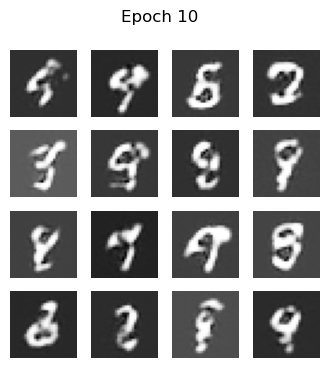

Epoch 11/50: 100%|██████████| 468/468 [00:27<00:00, 17.20it/s]


Epoch 11, D_loss: 0.2827, G_loss: 2.9803


Epoch 12/50: 100%|██████████| 468/468 [00:25<00:00, 18.23it/s]


Epoch 12, D_loss: 0.2889, G_loss: 3.5455


Epoch 13/50: 100%|██████████| 468/468 [00:26<00:00, 17.59it/s]


Epoch 13, D_loss: 0.3199, G_loss: 3.4776


Epoch 14/50: 100%|██████████| 468/468 [00:26<00:00, 17.41it/s]


Epoch 14, D_loss: 0.2473, G_loss: 2.8046


Epoch 15/50: 100%|██████████| 468/468 [00:26<00:00, 17.81it/s]


Epoch 15, D_loss: 0.2966, G_loss: 3.2974


Epoch 16/50: 100%|██████████| 468/468 [00:25<00:00, 18.24it/s]


Epoch 16, D_loss: 0.2889, G_loss: 2.9630


Epoch 17/50: 100%|██████████| 468/468 [00:25<00:00, 18.46it/s]


Epoch 17, D_loss: 0.2431, G_loss: 3.4413


Epoch 18/50: 100%|██████████| 468/468 [00:25<00:00, 18.42it/s]


Epoch 18, D_loss: 0.2756, G_loss: 3.8448


Epoch 19/50: 100%|██████████| 468/468 [00:27<00:00, 17.01it/s]


Epoch 19, D_loss: 0.2329, G_loss: 3.1203


Epoch 20/50: 100%|██████████| 468/468 [00:26<00:00, 17.49it/s]


Epoch 20, D_loss: 0.2464, G_loss: 3.7217


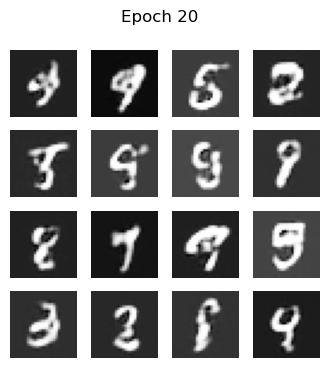

Epoch 21/50: 100%|██████████| 468/468 [00:26<00:00, 17.49it/s]


Epoch 21, D_loss: 0.3495, G_loss: 3.4816


Epoch 22/50: 100%|██████████| 468/468 [00:27<00:00, 17.10it/s]


Epoch 22, D_loss: 0.1984, G_loss: 3.6205


Epoch 23/50: 100%|██████████| 468/468 [00:27<00:00, 16.98it/s]


Epoch 23, D_loss: 0.2247, G_loss: 4.2210


Epoch 24/50: 100%|██████████| 468/468 [00:26<00:00, 17.39it/s]


Epoch 24, D_loss: 0.2818, G_loss: 3.9430


Epoch 25/50: 100%|██████████| 468/468 [00:27<00:00, 17.14it/s]


Epoch 25, D_loss: 0.1838, G_loss: 3.4858


Epoch 26/50: 100%|██████████| 468/468 [00:25<00:00, 18.22it/s]


Epoch 26, D_loss: 0.2381, G_loss: 3.3977


Epoch 27/50: 100%|██████████| 468/468 [00:26<00:00, 17.50it/s]


Epoch 27, D_loss: 0.1872, G_loss: 4.0136


Epoch 28/50: 100%|██████████| 468/468 [00:28<00:00, 16.69it/s]


Epoch 28, D_loss: 0.2598, G_loss: 4.3690


Epoch 29/50: 100%|██████████| 468/468 [00:27<00:00, 17.26it/s]


Epoch 29, D_loss: 0.1678, G_loss: 4.1239


Epoch 30/50: 100%|██████████| 468/468 [00:25<00:00, 18.21it/s]


Epoch 30, D_loss: 0.2423, G_loss: 3.2920


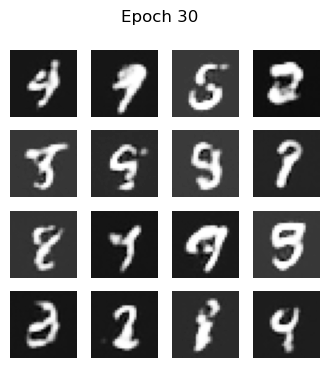

Epoch 31/50: 100%|██████████| 468/468 [00:26<00:00, 17.74it/s]


Epoch 31, D_loss: 0.1706, G_loss: 4.4043


Epoch 32/50: 100%|██████████| 468/468 [00:26<00:00, 17.43it/s]


Epoch 32, D_loss: 0.0948, G_loss: 5.1142


Epoch 33/50: 100%|██████████| 468/468 [00:25<00:00, 18.15it/s]


Epoch 33, D_loss: 0.1039, G_loss: 4.3818


Epoch 34/50: 100%|██████████| 468/468 [00:25<00:00, 18.26it/s]


Epoch 34, D_loss: 0.1729, G_loss: 3.6796


Epoch 35/50: 100%|██████████| 468/468 [00:25<00:00, 18.46it/s]


Epoch 35, D_loss: 0.1713, G_loss: 4.0814


Epoch 36/50: 100%|██████████| 468/468 [00:25<00:00, 18.57it/s]


Epoch 36, D_loss: 0.1125, G_loss: 4.8848


Epoch 37/50: 100%|██████████| 468/468 [00:27<00:00, 17.21it/s]


Epoch 37, D_loss: 0.1484, G_loss: 4.9739


Epoch 38/50: 100%|██████████| 468/468 [00:26<00:00, 17.64it/s]


Epoch 38, D_loss: 0.1452, G_loss: 4.3404


Epoch 39/50: 100%|██████████| 468/468 [00:25<00:00, 18.01it/s]


Epoch 39, D_loss: 0.1611, G_loss: 4.6483


Epoch 40/50: 100%|██████████| 468/468 [00:26<00:00, 17.69it/s]


Epoch 40, D_loss: 0.1441, G_loss: 4.0473


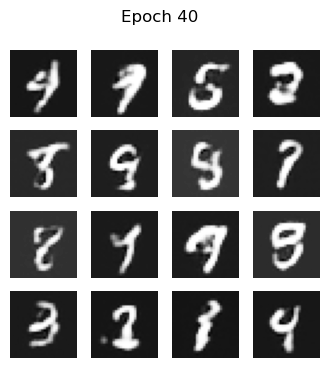

Epoch 41/50: 100%|██████████| 468/468 [00:27<00:00, 17.04it/s]


Epoch 41, D_loss: 0.1646, G_loss: 4.6688


Epoch 42/50: 100%|██████████| 468/468 [00:26<00:00, 17.76it/s]


Epoch 42, D_loss: 0.1196, G_loss: 4.1293


Epoch 43/50: 100%|██████████| 468/468 [00:26<00:00, 17.65it/s]


Epoch 43, D_loss: 0.1228, G_loss: 3.8190


Epoch 44/50: 100%|██████████| 468/468 [00:25<00:00, 18.10it/s]


Epoch 44, D_loss: 0.1230, G_loss: 4.0834


Epoch 45/50: 100%|██████████| 468/468 [00:25<00:00, 18.31it/s]


Epoch 45, D_loss: 0.1748, G_loss: 4.8564


Epoch 46/50: 100%|██████████| 468/468 [00:28<00:00, 16.63it/s]


Epoch 46, D_loss: 0.1406, G_loss: 4.5593


Epoch 47/50: 100%|██████████| 468/468 [00:27<00:00, 16.97it/s]


Epoch 47, D_loss: 0.1039, G_loss: 4.6486


Epoch 48/50: 100%|██████████| 468/468 [00:25<00:00, 18.33it/s]


Epoch 48, D_loss: 0.1766, G_loss: 4.2277


Epoch 49/50: 100%|██████████| 468/468 [00:26<00:00, 17.43it/s]


Epoch 49, D_loss: 0.0916, G_loss: 4.7476


Epoch 50/50: 100%|██████████| 468/468 [00:27<00:00, 16.91it/s]


Epoch 50, D_loss: 0.1027, G_loss: 5.0000


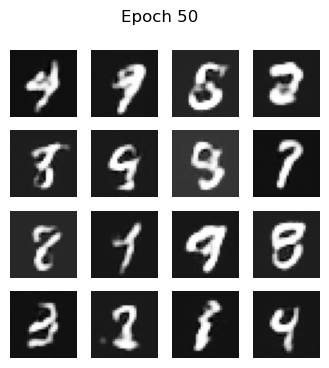

In [14]:
# 创建固定的测试输入（噪声）
seed = tf.random.normal([16, noise_dim])

# 主训练循环
for epoch in range(1, epochs + 1):
    for real_batch in tqdm(train_dataset,desc = f"Epoch {epoch}/{epochs}"):
        d_loss, g_loss = train_step(real_batch, epoch)

    print(f'Epoch {epoch}, D_loss: {d_loss:.4f}, G_loss: {g_loss:.4f}')

    if epoch % 10 == 0:
        generate_and_save_images(generator, epoch, seed)

In [15]:
def get_steps_per_epoch(total_samples, batch_size):
    """计算每个epoch的训练步数"""
    return math.ceil(total_samples / batch_size)

steps_per_epoch = get_steps_per_epoch(train_samples, batch_size)
print(f"steps_per_epoch = {steps_per_epoch}")

steps_per_epoch = 469


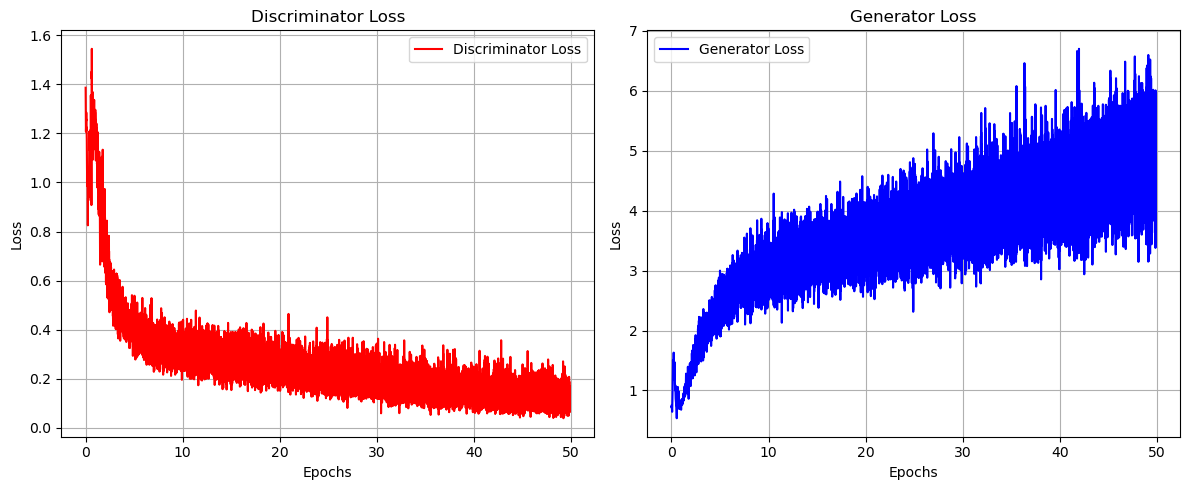

In [16]:
plot_gan_losses(d_losses, g_losses, steps_per_epoch)

In [17]:
generator.save('generator_model_path.h5')  # 或者用 .tf 格式
discriminator.save('discriminator_model_path.h5')